# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
from tf_config import tf_config
tf.random.set_seed(30)
import cv2
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
project_folder='/home/datasets/Project_data'
#train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
#batch_size = #experiment with the batch size

#### Plotting

In [5]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=84,image_width=84):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [7]:
# importing some other libraries which will be needed for model building.

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, TimeDistributed,BatchNormalization, Activation,Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

#### Sample Model

In [7]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
     #   model.add(Conv3D(16, (3, 3, 3), padding='same',
     #            input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
     #   model.add(Activation('relu'))
     #   model.add(BatchNormalization())
     #   model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same',  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [8]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 160, 160, 32)  800       
_________________________________________________________________
activation (Activation)      (None, 30, 160, 160, 32)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 160, 160, 32)  128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 80, 80, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 80, 80, 64)    16448     
_________________________________________________________________
activation_1 (Activation)    (None, 15, 80, 80, 64)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 80, 80, 64)    2

#### Sample Cropping

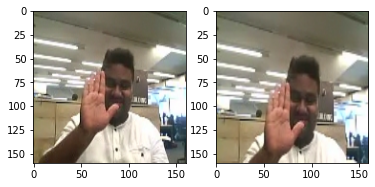

In [9]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])

#### Experimenting with Image resolution, number of frames to use and batch_size

In [10]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 7171173
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.2757 - categorical_accuracy: 0.5234
Epoch 00001: val_loss improved from inf to 2.17199, saving model to model_init_2021-08-0104_05_55.221176/model-00001-1.27569-0.52338-2.17199-0.17000.h5
34/34 [==============================] - 139s 4s/step - loss: 1.2757 - categorical_accuracy: 0.5234 - val_loss: 2.1720 - val_categorical_accuracy: 0.1700
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 0.6826 - categorical_accuracy: 0.7421
Epoch 00002: val_loss did not improve from 2.17199
34/34 [==============================] - 141s 4s/step - loss: 0.6826 - categorical_accuracy: 0.7421 - val_loss: 3.8313 - val_categorical_accuracy: 0.2100


In [11]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 19754085
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.3830 - categorical_accuracy: 0.4706
Epoch 00001: val_loss improved from inf to 9.08144, saving model to model_init_2021-08-0104_11_25.935895/model-00001-1.38297-0.47059-9.08144-0.23000.h5
45/45 [==============================] - 165s 4s/step - loss: 1.3830 - categorical_accuracy: 0.4706 - val_loss: 9.0814 - val_categorical_accuracy: 0.2300
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 0.7810 - categorical_accuracy: 0.7059
Epoch 00002: val_loss improved from 9.08144 to 8.28352, saving model to model_init_2021-08-0104_11_25.935895/model-00002-0.78097-0.70588-8.28352-0.21000.h5
45/45 [==============================] - 165s 4s/step - loss: 0.7810 - categorical_accuracy: 0.7059 - val_loss: 8.2835 - val_categorical_accuracy: 0.2100


In [12]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 13200485
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.3695 - categorical_accuracy: 0.4962
Epoch 00001: val_loss improved from inf to 4.86002, saving model to model_init_2021-08-0104_17_00.945861/model-00001-1.36955-0.49623-4.86002-0.21000.h5
23/23 [==============================] - 88s 4s/step - loss: 1.3695 - categorical_accuracy: 0.4962 - val_loss: 4.8600 - val_categorical_accuracy: 0.2100
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 0.7773 - categorical_accuracy: 0.7044
Epoch 00002: val_loss did not improve from 4.86002
23/23 [==============================] - 88s 4s/step - loss: 0.7773 - categorical_accuracy: 0.7044 - val_loss: 34.3247 - val_categorical_accuracy: 0.2100


#### Model 1

##### Base Model - Batch Size = 40 and No. of Epochs = 15

In [13]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_13 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 80, 80, 32)   

In [15]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.4745 - categorical_accuracy: 0.4510
Epoch 00001: val_loss improved from inf to 2.08431, saving model to model_init_2021-08-0104_20_01.972569/model-00001-1.47450-0.45098-2.08431-0.16000.h5
17/17 [==============================] - 109s 6s/step - loss: 1.4745 - categorical_accuracy: 0.4510 - val_loss: 2.0843 - val_categorical_accuracy: 0.1600
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.7772 - categorical_accuracy: 0.6968
Epoch 00002: val_loss did not improve from 2.08431
17/17 [==============================] - 108s 6s/step - loss: 0.7772 - categorical_accuracy: 0.6968 - val_loss: 2.6721 - val_categorical_accuracy: 0.1900
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.5390 - categorical_accuracy: 0.8069
Epoch 00003: val_loss did not improve from 2.08431
17/17 [==============================] - 106s 6s/step - loss: 0.5390 - categorical_accuracy: 0.806

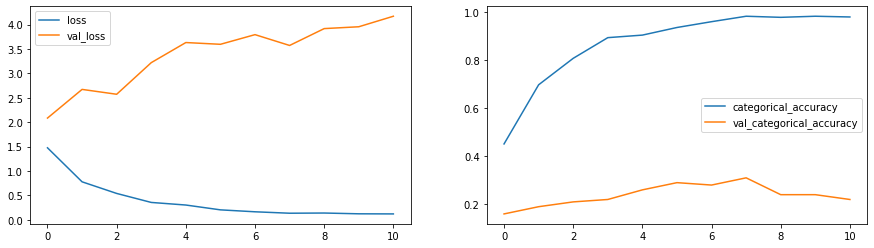

In [16]:
plot(history_model1)

##### Model is Overfitting

#### Model 2

##### Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [17]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_17 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 10, 80, 80, 32)   

In [18]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9639 - categorical_accuracy: 0.3974
Epoch 00001: val_loss improved from inf to 2.60772, saving model to model_init_2021-08-0104_40_03.851468/model-00001-1.96390-0.39744-2.60772-0.27000.h5
34/34 [==============================] - 200s 6s/step - loss: 1.9639 - categorical_accuracy: 0.3974 - val_loss: 2.6077 - val_categorical_accuracy: 0.2700
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3114 - categorical_accuracy: 0.5596
Epoch 00002: val_loss did not improve from 2.60772
34/34 [==============================] - 199s 6s/step - loss: 1.3114 - categorical_accuracy: 0.5596 - val_loss: 4.1869 - val_categorical_accuracy: 0.2900
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9967 - categorical_accuracy: 0.6350
Epoch 00003: val_loss did not improve from 2.60772
34/34 [==============================] - 199s 6s/step - loss: 0.9967 - categorical_accuracy: 0.635

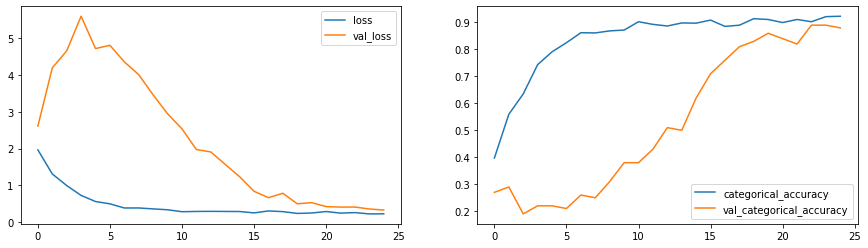

In [19]:
plot(history_model2)

##### We Observed that Training accuracy is 92% and Validation Accuracy is 88% and loss also very less. Next we will try more experiments by reducing the filter size and image resolution and see if get better results. 

#### Model 3

##### Reduce filter size to (2,2,2) and image res to 120 x 120, - Batch Size = 30 and No. of Epochs = 25

In [20]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_20 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_21 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 8, 60, 60, 32)    

In [22]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1599 - categorical_accuracy: 0.3326
Epoch 00001: val_loss improved from inf to 2.02191, saving model to model_init_2021-08-0106_05_28.873904/model-00001-2.15990-0.33258-2.02191-0.16000.h5
23/23 [==============================] - 153s 7s/step - loss: 2.1599 - categorical_accuracy: 0.3326 - val_loss: 2.0219 - val_categorical_accuracy: 0.1600
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4231 - categorical_accuracy: 0.5030
Epoch 00002: val_loss did not improve from 2.02191
23/23 [==============================] - 151s 7s/step - loss: 1.4231 - categorical_accuracy: 0.5030 - val_loss: 3.1114 - val_categorical_accuracy: 0.1700
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2121 - categorical_accuracy: 0.5807
Epoch 00003: val_loss did not improve from 2.02191
23/23 [==============================] - 152s 7s/step - loss: 1.2121 - categorical_accuracy: 0.580

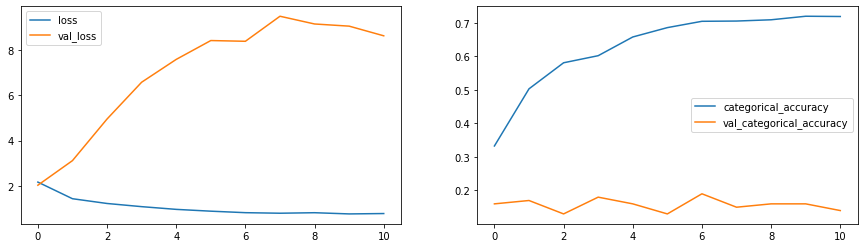

In [23]:
plot(history_model3)

##### Accuracy has reduced. Lets trying adding more layers

#### Model 4

##### Adding more layers - Batch Size = 20 and No. of Epochs = 25

In [24]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_25 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 8, 60, 60, 16)    

In [26]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8922 - categorical_accuracy: 0.4042
Epoch 00001: val_loss improved from inf to 2.21130, saving model to model_init_2021-08-0106_32_57.385700/model-00001-1.89224-0.40422-2.21130-0.21000.h5
34/34 [==============================] - 147s 4s/step - loss: 1.8922 - categorical_accuracy: 0.4042 - val_loss: 2.2113 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3392 - categorical_accuracy: 0.5430
Epoch 00002: val_loss did not improve from 2.21130
34/34 [==============================] - 148s 4s/step - loss: 1.3392 - categorical_accuracy: 0.5430 - val_loss: 2.7300 - val_categorical_accuracy: 0.2500
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1322 - categorical_accuracy: 0.6026
Epoch 00003: val_loss did not improve from 2.21130
34/34 [==============================] - 148s 4s/step - loss: 1.1322 - categorical_accuracy: 0.602

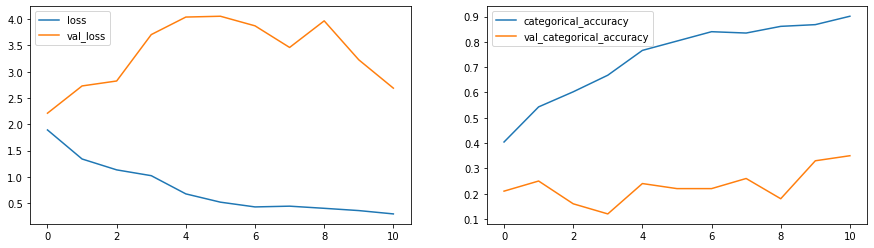

In [27]:
plot(history_model4)

#### Model 5

##### Adding dropout at convolution layers

In [28]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [29]:

conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_32 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_33 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 8, 60, 60, 16)    

In [30]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - ETA: 0s - loss: 1.7786 - categorical_accuracy: 0.3627
Epoch 00001: val_loss improved from inf to 2.51383, saving model to model_init_2021-08-0107_01_03.153104/model-00001-1.77857-0.36275-2.51383-0.25000.h5
34/34 [==============================] - 156s 5s/step - loss: 1.7786 - categorical_accuracy: 0.3627 - val_loss: 2.5138 - val_categorical_accuracy: 0.2500
Epoch 2/15
34/34 [==============================] - ETA: 0s - loss: 1.4044 - categorical_accuracy: 0.4910
Epoch 00002: val_loss did not improve from 2.51383
34/34 [==============================] - 153s 4s/step - loss: 1.4044 - categorical_accuracy: 0.4910 - val_loss: 3.6967 - val_categorical_accuracy: 0.2100
Epoch 3/15
34/34 [==============================] - ETA: 0s - loss: 1.0820 - categorical_accuracy: 0.5965
Epoch 00003: val_loss did not improve from 2.51383
34/34 [==============================] - 155s 5s/step - loss: 1.0820 - categorical_accuracy: 0.596

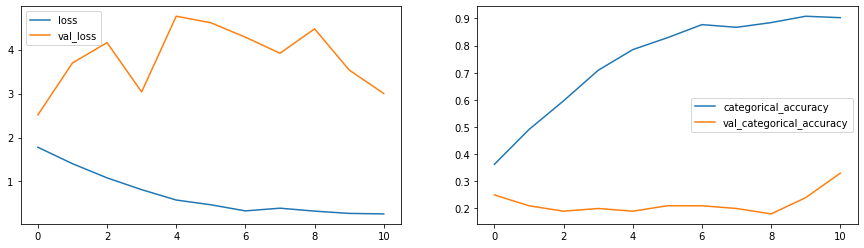

In [31]:
plot(history_model5)

Overfitting again!! Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.

#### Model 6

##### Reducing the number of parameters

In [32]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [33]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation_40 (Activation)   (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_41 (Activation)   (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 8, 50, 50, 32)    

In [34]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7771 - categorical_accuracy: 0.3725
Epoch 00001: val_loss improved from inf to 2.17184, saving model to model_init_2021-08-0107_29_02.271593/model-00001-1.77713-0.37255-2.17184-0.25000.h5
34/34 [==============================] - 145s 4s/step - loss: 1.7771 - categorical_accuracy: 0.3725 - val_loss: 2.1718 - val_categorical_accuracy: 0.2500
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0667 - categorical_accuracy: 0.6063
Epoch 00002: val_loss did not improve from 2.17184
34/34 [==============================] - 143s 4s/step - loss: 1.0667 - categorical_accuracy: 0.6063 - val_loss: 3.1171 - val_categorical_accuracy: 0.1900
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9059 - categorical_accuracy: 0.6561
Epoch 00003: val_loss did not improve from 2.17184
34/34 [==============================] - 145s 4s/step - loss: 0.9059 - categorical_accuracy: 0.6561

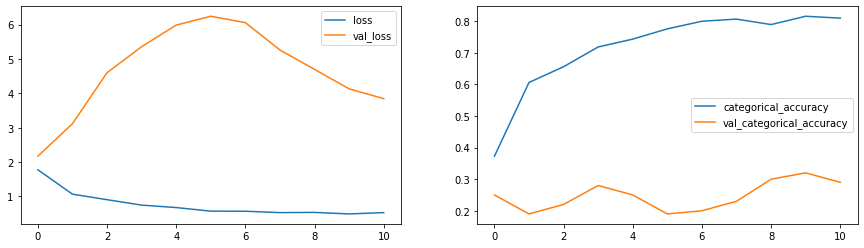

In [35]:
plot(history_model6)

For the above low memory foot print model, we get the best validation accuracy of 81%

#### Model 7 - Reducing the number of parameters again

In [9]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_1 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 60, 60, 32)     1

In [11]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8245 - categorical_accuracy: 0.3469
Epoch 00001: val_loss improved from inf to 1.85692, saving model to model_init_2021-08-0108_20_48.885814/model-00001-1.82446-0.34691-1.85692-0.21000.h5
34/34 [==============================] - 144s 4s/step - loss: 1.8245 - categorical_accuracy: 0.3469 - val_loss: 1.8569 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1929 - categorical_accuracy: 0.5332
Epoch 00002: val_loss did not improve from 1.85692
34/34 [==============================] - 144s 4s/step - loss: 1.1929 - categorical_accuracy: 0.5332 - val_loss: 2.8733 - val_categorical_accuracy: 0.2200
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9456 - categorical_accuracy: 0.6440
Epoch 00003: val_loss did not improve from 1.85692
34/34 [================

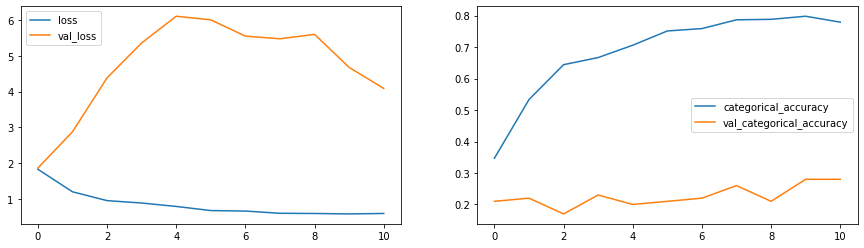

In [12]:
plot(history_model7)

For the above low memory foot print model the best validation accuracy of 77%

#### Model 8 - CNN- LSTM Model

In [11]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [27]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)   

In [28]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.3249 - categorical_accuracy: 0.4314
Epoch 00001: val_loss improved from inf to 1.60269, saving model to model_init_2021-08-0109_08_26.427139/model-00001-1.32494-0.43137-1.60269-0.25000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.3249 - categorical_accuracy: 0.4314 - val_loss: 1.6027 - val_categorical_accuracy: 0.2500
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0133 - categorical_accuracy: 0.6056
Epoch 00002: val_loss did not improve from 1.60269
34/34 [==============================] - 161s 5s/step - loss: 1.0133 - categorical_accuracy: 0.6056 - val_loss: 2.9360 - val_categorical_accuracy: 0.1600
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8350 - categorical_accuracy: 0.6878
Epoch 00003: val_loss did not improve from 1.60269
34/34 [==============================] - 161s 5s/step - loss: 0.8350 - categorical_accuracy: 0.687

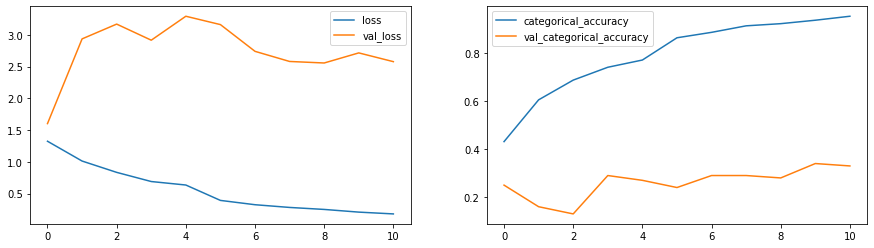

In [29]:
plot(history_model8)

For CNN - LSTM model we get a training accuracy of 95% and Validation accuracy of 33%

As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

Let's apply some data augmentation & check the model performance.

In [8]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

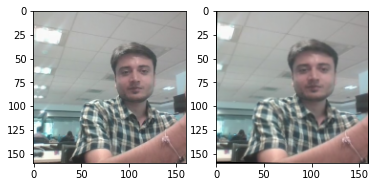

In [9]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])

#### Model 9 with Augmentation

(3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [34]:
class ModelConv3D9(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [35]:
conv_3d9=ModelConv3D9()
conv_3d9.initialize_path(project_folder)
conv_3d9.initialize_image_properties(image_height=160,image_width=160)
conv_3d9.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=20)
conv_3d9_model=conv_3d9.define_model(dense_neurons=256,dropout=0.5)
conv_3d9_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_5 (Activation)    (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 10, 80, 80, 32)   

In [37]:
print("Total Params:", conv_3d9_model.count_params())
history_model9=conv_3d9.train_model(conv_3d9_model,augment_data=True)

Total Params: 3638981
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.7596 - categorical_accuracy: 0.4103
Epoch 00001: saving model to model_init_2021-08-0109_46_43.405513/model-00001-1.75960-0.41026-3.19604-0.21000.h5
34/34 [==============================] - 211s 6s/step - loss: 1.7596 - categorical_accuracy: 0.4103 - val_loss: 3.1960 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.3866 - categorical_accuracy: 0.5128
Epoch 00002: saving model to model_init_2021-08-0109_46_43.405513/model-00002-1.38665-0.51282-4.53745-0.19000.h5
34/34 [==============================] - 209s 6s/step - loss: 1.3866 - categorical_accuracy: 0.5128 - val_loss: 4.5375 - val_categorical_accuracy: 0.1900
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 1.1758 - categorical_accuracy: 0.6041
Epoch 00003: saving model to model_init_2021-08-0109_46_43.405513/model-00003-1.17581-0.60407-5.24504-0.23000.h5
34/34 [======

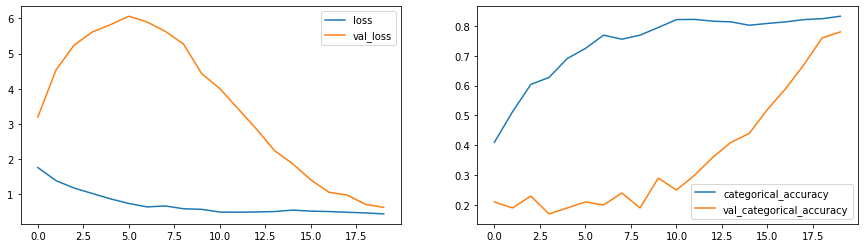

In [38]:

plot(history_model9)

#### Model 10 with Augmentation

(2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [39]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [40]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=120,image_width=120)
conv_3d10.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=25)
conv_3d10_model=conv_3d10.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_9 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 60, 60, 32)    

In [41]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 1762613
Epoch 1/25
23/23 [==============================] - ETA: 0s - loss: 2.1393 - categorical_accuracy: 0.3288
Epoch 00001: saving model to model_init_2021-08-0110_58_27.699393/model-00001-2.13934-0.32881-1.84287-0.16000.h5
23/23 [==============================] - 146s 6s/step - loss: 2.1393 - categorical_accuracy: 0.3288 - val_loss: 1.8429 - val_categorical_accuracy: 0.1600
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.4894 - categorical_accuracy: 0.4962
Epoch 00002: saving model to model_init_2021-08-0110_58_27.699393/model-00002-1.48939-0.49623-2.88113-0.19000.h5
23/23 [==============================] - 146s 6s/step - loss: 1.4894 - categorical_accuracy: 0.4962 - val_loss: 2.8811 - val_categorical_accuracy: 0.1900
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.2024 - categorical_accuracy: 0.5822
Epoch 00003: saving model to model_init_2021-08-0110_58_27.699393/model-00003-1.20239-0.58220-3.27384-0.23000.h5
23/23 [======

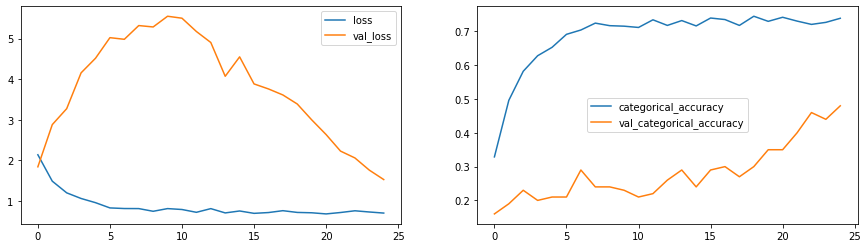

In [42]:
plot(history_model10)

##### Model 11 with Augmentation

##### Adding more layers - Similar to model 4

In [11]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [12]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d11_model=conv_3d11.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0

In [13]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 2556533
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.1192 - categorical_accuracy: 0.3348
Epoch 00001: saving model to model_init_2021-08-0112_28_09.221090/model-00001-2.11924-0.33484-2.07475-0.21000.h5
34/34 [==============================] - 142s 4s/step - loss: 2.1192 - categorical_accuracy: 0.3348 - val_loss: 2.0747 - val_categorical_accuracy: 0.2100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6175 - categorical_accuracy: 0.4480
Epoch 00002: saving model to model_init_2021-08-0112_28_09.221090/model-00002-1.61748-0.44796-3.13317-0.16000.h5
34/34 [==============================] - 144s 4s/step - loss: 1.6175 - categorical_accuracy: 0.4480 - val_loss: 3.1332 - val_categorical_accuracy: 0.1600
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4221 - categorical_accuracy: 0.4962
Epoch 00003: saving model to model_init_2021-08-01

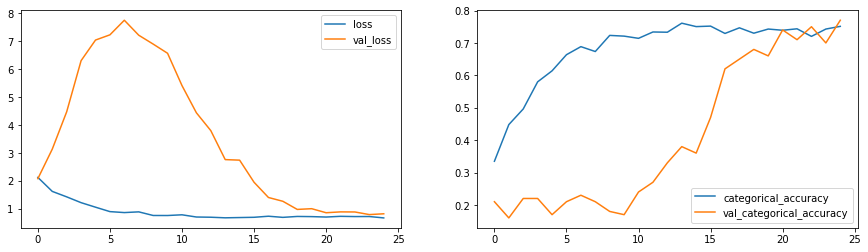

In [14]:

plot(history_model11)

#### Model 12 with Augmentation

##### Adding dropouts - Similar to Model 5

In [15]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [16]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)    

In [17]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9432 - categorical_accuracy: 0.3431
Epoch 00001: saving model to model_init_2021-08-0113_28_43.425324/model-00001-1.94322-0.34314-2.31888-0.16000.h5
34/34 [==============================] - 148s 4s/step - loss: 1.9432 - categorical_accuracy: 0.3431 - val_loss: 2.3189 - val_categorical_accuracy: 0.1600
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4165 - categorical_accuracy: 0.5038
Epoch 00002: saving model to model_init_2021-08-0113_28_43.425324/model-00002-1.41648-0.50377-3.32084-0.14000.h5
34/34 [==============================] - 154s 5s/step - loss: 1.4165 - categorical_accuracy: 0.5038 - val_loss: 3.3208 - val_categorical_accuracy: 0.1400
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2164 - categorical_accuracy: 0.5611
Epoch 00003: saving model to model_init_2021-08-0113_28_43.425324/model-00003-1.21638-0.56109-3.93324-0.16000.h5
34/34 [======

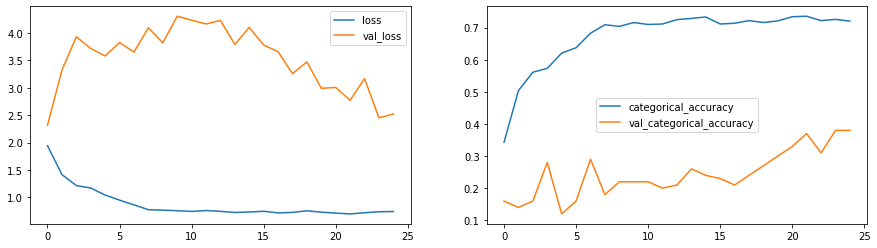

In [18]:

plot(history_model12)

#### Model 13 with Augmentation

##### Reducing network parameters - Similar to Model 6

In [9]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=100,image_width=100)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(dense_neurons=128,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 50, 50, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 8, 50, 50, 32)     4128      
_________________________________________________________________
activation_1 (Activation)    (None, 8, 50, 50, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 50, 50, 32)     1

In [11]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 696645
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8423 - categorical_accuracy: 0.3356
Epoch 00001: saving model to model_init_2021-08-0115_16_24.161722/model-00001-1.84234-0.33560-1.78759-0.16000.h5
34/34 [==============================] - 151s 4s/step - loss: 1.8423 - categorical_accuracy: 0.3356 - val_loss: 1.7876 - val_categorical_accuracy: 0.1600
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1636 - categorical_accuracy: 0.5422
Epoch 00002: saving model to model_init_2021-08-0115_16_24.161722/model-00002-1.16362-0.54223-2.77546-0.15000.h5
34/34 [==============================] - 151s 4s/step - loss: 1.1636 - categorical_accuracy: 0.5422 - val_loss: 2.7755 - val_categorical_accuracy: 0.1500
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9141 - categorical_accuracy: 0.6456
Epoch 00003: saving model to model_init_2021-08-011

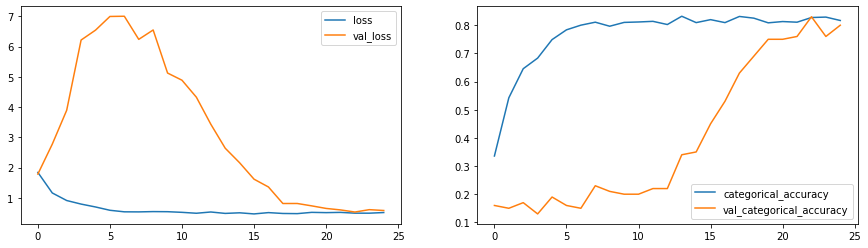

In [12]:
plot(history_model13)

#### Model 14 with Augmentation

##### Reducing network parameters again - Similar to model 7

In [13]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=120,image_width=120)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d14_model=conv_3d14.define_model(dense_neurons=64,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_4 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 8, 60, 60, 32)     13856     
_________________________________________________________________
activation_5 (Activation)    (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 60, 60, 32)    

In [15]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7783 - categorical_accuracy: 0.3612
Epoch 00001: saving model to model_init_2021-08-0116_16_55.941401/model-00001-1.77829-0.36124-2.00228-0.16000.h5
34/34 [==============================] - 152s 4s/step - loss: 1.7783 - categorical_accuracy: 0.3612 - val_loss: 2.0023 - val_categorical_accuracy: 0.1600
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.1711 - categorical_accuracy: 0.5430
Epoch 00002: saving model to model_init_2021-08-0116_16_55.941401/model-00002-1.17106-0.54299-3.18128-0.14000.h5
34/34 [==============================] - 150s 4s/step - loss: 1.1711 - categorical_accuracy: 0.5430 - val_loss: 3.1813 - val_categorical_accuracy: 0.1400
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9867 - categorical_accuracy: 0.6244
Epoch 00003: saving model to model_init_2021-08-0116_16_55.941401/model-00003-0.98670-0.62443-4.34502-0.16000.h5
34/34 [=======

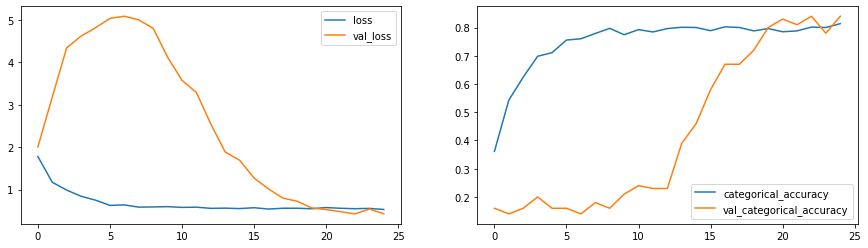

In [16]:
plot(history_model14)

#### Model 15 with Augmentation

##### CNN LSTM with GRU - Similar to Model 8

In [10]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [11]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)    1

In [12]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4510 - categorical_accuracy: 0.4065
Epoch 00001: saving model to model_init_2021-08-0117_32_06.399998/model-00001-1.45101-0.40649-1.70215-0.21000.h5
34/34 [==============================] - 162s 5s/step - loss: 1.4510 - categorical_accuracy: 0.4065 - val_loss: 1.7022 - val_categorical_accuracy: 0.2100
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.9200 - categorical_accuracy: 0.6554
Epoch 00002: saving model to model_init_2021-08-0117_32_06.399998/model-00002-0.91999-0.65535-2.02426-0.22000.h5
34/34 [==============================] - 164s 5s/step - loss: 0.9200 - categorical_accuracy: 0.6554 - val_loss: 2.0243 - val_categorical_accuracy: 0.2200
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.6504 - categorical_accuracy: 0.7602
Epoch 00003: saving model to model_init_2021-08-01

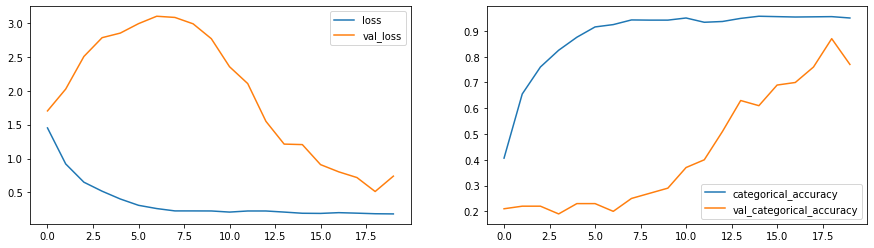

In [13]:
plot(history_model15)

We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

After doing all the experiments, we finalized Model 15 - CNN+LSTM with GRU, which performed well.

Reason:

- (Training Accuracy : 95%, Validation Accuracy : 77%)

- Number of Parameters(2,573,925)less according to other models performance

- Learning rate gradually decreacing after 9 Epoch

The best weights of CNN+LSTM with GRU: model_init_2021-08-0117_32_06.399998/model-00020-0.18241-0.95023-0.73962-0.77000.h5 (19 MB). we considered this weight for model testing, Let's have look at the performance below

Loading model and Testing

In [9]:
import time
from tensorflow.keras.models import load_model
model = load_model('model_init_2021-08-0117_32_06.399998/model-00020-0.18241-0.95023-0.73962-0.77000.h5')

In [12]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [13]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [14]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 2 1 2 1 0 2 1 3 1 3 1 3 1 2 0 1 0 1 0]
